# MNIST Classification

We'll build a dense neural network to classify images and apply it to the classical problem of the classification of the hand-written digits in the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We've organized these images in two folders named `train` and `test` in the GitHub repository https://github.com/DeepTrackAI/MNIST_dataset:

> train/0_000000.png<br>
> train/0_000001.png<br>
> ...<br>
> train/1_000000.png<br>
> ...<br>

> test/0_000000.png<br>
> ...<br>
> test/1_000000.png<br>
> ...<br>

The first digit in the filename is the label.

The following code will download the MINST dataset repository only if the `MNIST_dataset` directory doesn't already exist.

In [1]:
import os

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

train_path = os.path.join("MNIST_dataset", "mnist", "train")
train_images_paths = os.listdir(train_path)

print(f"{len(train_images_paths)} training images")

60000 training images


We can use `matplotlib` to load the images into `numpy` arrays. Since the MNIST dataset is small enough to be held in memory, we can load all images at once. For larger datasets, we'd need to load the images as needed during training.

In [2]:
import matplotlib.pyplot as plt

train_images = []
for path in train_images_paths:
    image = plt.imread(os.path.join(train_path, path))
    train_images.append(image)

print(f"{len(train_images)} training images with shape {train_images[0].shape}")

60000 training images with shape (28, 28)


Since the digit is encoded as the first character of the filename, we can extract the groundtruth labels from the filenames.

In [3]:
train_digits = []
for path in train_images_paths:
    filename = os.path.basename(path)
    digit = int(filename[0])
    train_digits.append(digit)

print(f"{len(train_digits)} training ground-truth digits")

60000 training ground-truth digits


We can now visualize some of the MNIST digits.

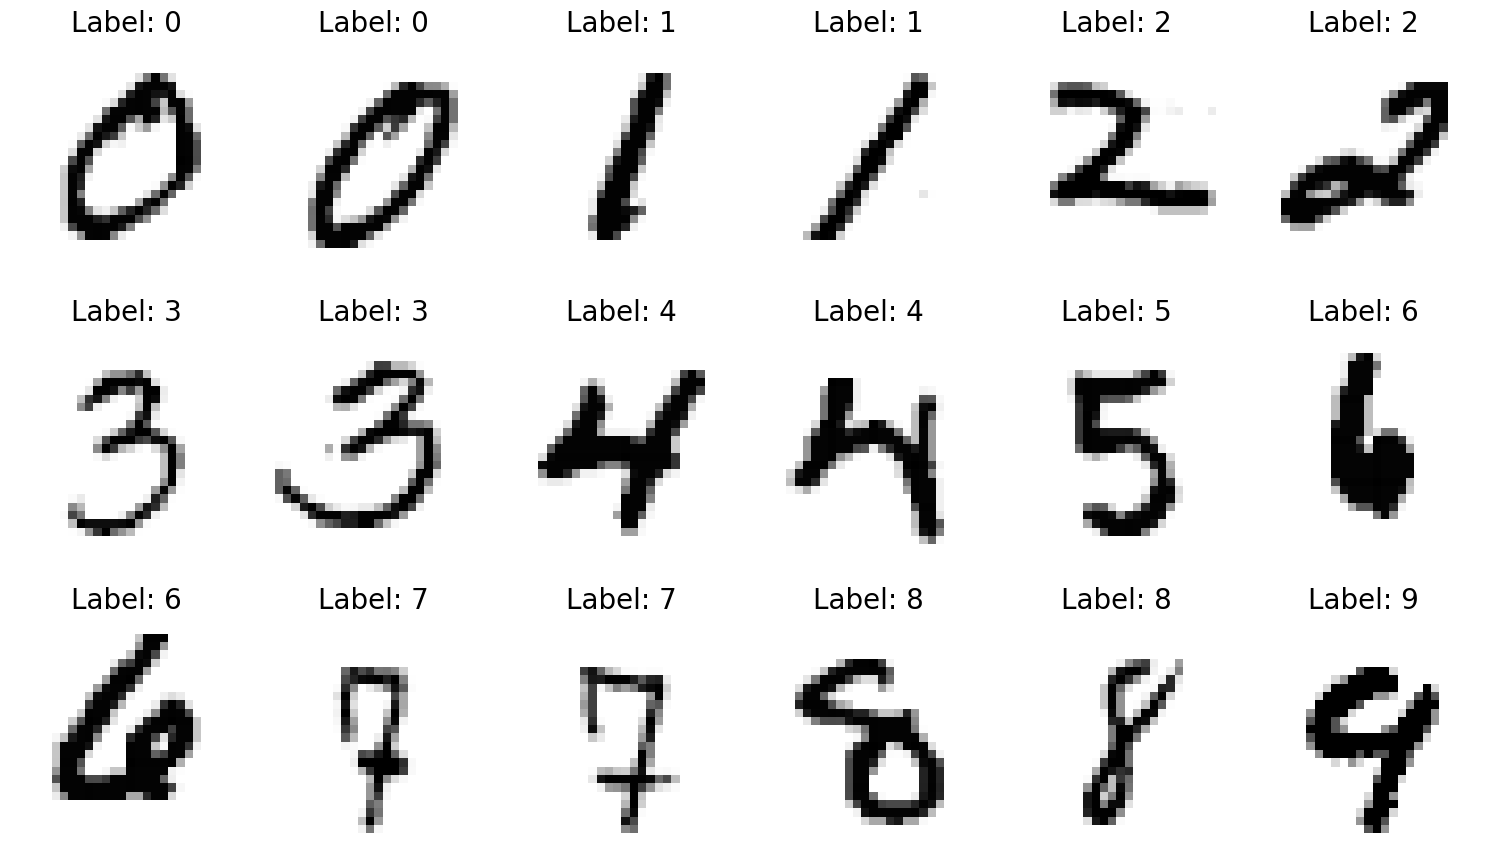

In [4]:
import numpy as np

idx_images_to_show = np.linspace(0, 60000, 18, dtype=int, endpoint=False)

plt.figure(figsize=(15, 9))

for i in range(18):
    idx = idx_images_to_show[i]

    plt.subplot(3, 6, i + 1)
    plt.title(f"Label: {train_digits[idx]}", fontsize=20)
    plt.imshow(train_images[idx].squeeze(), cmap="Greys") 
    plt.axis("off")

plt.tight_layout()
plt.show()

## First Neural Network

We will create, train, and evaluate a first version of the neural network.

### Neural Network Model

We use the class `MultiLayerPerceptron` from `deeplay` to define a small _dense neural network_ (often called also _multi-layer perceptron_ or _fully connected neural network_) with 784 = 28 x 28 inputs (one for each pixel,`in_features=28 * 28`), two hidden layers with 32 neurons each (`hidden_features=[32, 32]`) with _sigmoid_ activation (`.blocks.activation.configure(Sigmoid)`), and an output layer with 10 neurons (`out_features=10`) with _sigmoid_ activation (one for each digit, `out_activation=Sigmoid`). We then call `.create()` to create the neural network.

The output will be a vector of 10 numbers between 0 and 1, which can be loosely interpreted as probabilities, so that the predicted digit is the one with the highest output value.

In [5]:
import deeplay as dl
from torch.nn import Sigmoid

mlp_template = dl.MultiLayerPerceptron(in_features=28 * 28, 
                                       hidden_features=[32, 32], 
                                       out_features=10, 
                                       out_activation=Sigmoid)
mlp_template.blocks.activation.configure(Sigmoid)
mlp_model = mlp_template.create()

print(f"{sum(p.numel() for p in mlp_model.parameters())} trainable parameters")
print(mlp_model)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


26506 trainable parameters
MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LayerActivationNormalizationBlock(
      (layer): Linear(in_features=784, out_features=32, bias=True)
      (activation): Sigmoid()
      (normalization): Identity()
    )
    (1): LayerActivationNormalizationBlock(
      (layer): Linear(in_features=32, out_features=32, bias=True)
      (activation): Sigmoid()
      (normalization): Identity()
    )
  )
  (out_layer): LayerActivationNormalizationBlock(
    (layer): Linear(in_features=32, out_features=10, bias=True)
    (activation): Sigmoid()
    (normalization): Identity()
  )
)


### Application as Classifier

We use the `Classifier` application class from `deeplay` to define what we want to do with the neural network (e.g., determining the training logic and adding some convenient metrics such as accuracy).

We add to the classifier the model we have just created (`model=mlp_template`).  Then, we set the number of classes (`num_classes=10`), convert the groundtruth digits to one-hot vectors to match the output of the model (`make_targets_one_hot=True`), set _mean squared error_ as loss function (`loss=MSELoss()`), set _stochastic gradient descent_ as optimizer with learning rate 0.1 (`optimizer=dl.SGD(lr=.1)`).

In [10]:
from torch.nn import MSELoss

classifier_template = dl.Classifier(
    model=mlp_template,
    num_classes=10,
    make_targets_one_hot=True,
    loss=MSELoss(),
    optimizer=dl.SGD(lr=.1),
)

classifier = classifier_template.create()

print(classifier)

Classifier(
  (loss): MSELoss()
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LayerActivationNormalizationBlock(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (activation): Sigmoid()
        (normalization): Identity()
      )
      (1): LayerActivationNormalizationBlock(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (activation): Sigmoid()
        (normalization): Identity()
      )
    )
    (out_layer): LayerActivationNormalizationBlock(
      (layer): Linear(in_features=32, out_features=10, bias=True)
      (activation): Sigmoid()
      (normalization): Identity()
    )
  )
  (optimizer): SGD[

### Dataloader

A `DataLoader` object manages the data to be passed to the neural network. The simplest way to create a dataloader from data already in memory is to create a list of `(sample, ground_truth)` tuples. This can easily be achieved using the Python native function `zip()`.

For the training, it is important to shuffle the data, while this is not so relevant for the testing.

In [11]:
train_images_digits = list(zip(train_images, train_digits))
train_dataloader = dl.DataLoader(train_images_digits, shuffle=True)

print(f"{len(train_dataloader)} train batches")

60000 train batches


### Trainer

A `Trainer` object manages the training and evaluation, e.g., deciding what hardware to use, when to stop training, whether to utilize the GPU, and when to save the model, log the training, and evaluate the metrics. 

For now, we will create a trainer for a single epoch (an epoch is a single pass through the entire training set, `max_epochs=1`) and with automatic hardware acceleration (it will use a GPU if available, otherwise a CPU, `accelerator="auto"`).

In [12]:
trainer = dl.Trainer(max_epochs=1, accelerator="auto")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [13]:
trainer.fit(classifier, train_dataloader)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | MSELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | model         | MultiLayerPerceptron | 26.5 K
5 | optimizer     | SGD                  | 0     
-------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


### Testing

Let's check the test set. We can reuse the trainer to test the model on the test set.

In [14]:
test_path = os.path.join("MNIST_dataset", "mnist", "test")
test_images_paths = os.listdir(test_path)

print(f"{len(test_images_paths)} test images")

test_images = []
for path in test_images_paths:
    image = plt.imread(os.path.join(test_path, path))
    test_images.append(image)

print(f"{len(test_images)} test images with shape {test_images[0].shape}")

test_digits = []
for path in test_images_paths:
    filename = os.path.basename(path)
    digit = int(filename[0])
    test_digits.append(digit)

print(f"{len(test_digits)} test ground-truth digits")

test_images_digits = list(zip(test_images, test_digits))
test_dataloader = dl.DataLoader(test_images_digits, shuffle=False)

print(f"{len(test_dataloader)} test batches")

trainer.test(classifier, test_dataloader)

10000 test images


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


10000 test images with shape (28, 28)
10000 test ground-truth digits
10000 test batches


c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.5830000042915344      │
│       test_loss_epoch        │     0.05539002642035484      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.05539002642035484,
  'testMulticlassAccuracy_epoch': 0.5830000042915344}]

### Confusion Matrix

A _confusion matrix_ illustrates the performance of a classifier and to gain insights to improve its architecture and training hyperparameters. 

> A confusion matrix is a square matrix with a number of rows and columns equal to the number of classes in the classification problem (here, 10). Each row and each column corresponds to one class, ordered arbitrarily but equally for the two axes (here, we have a natural ordering of the classes, which is the order of the digits). An element $c_{i,j}$ of the confusion matrix represents the number of times the classifier assigned the predicted class $j$ to the actual class $i$. For example, in our case, $c_{3,5}$ corresponds to the number of times the neural network, when given an image depicting the digit $3$, classifies it as the digit $5$.

We've assigned the `pred_digit` to the first axis (rows) and the `gt_digit` to the second axis (columns), but the opposite is also a valid (and comon) choice.

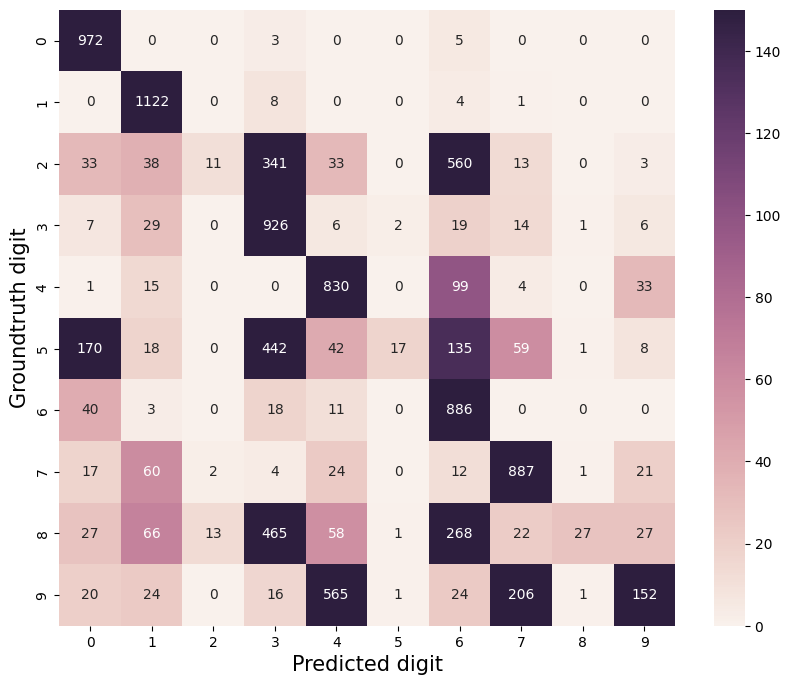

In [15]:
def plot_confusion_matrix(classifier, trainer, dataloader):
    from seaborn import heatmap, cubehelix_palette

    confusion_matrix = np.zeros((10, 10), dtype=int)
    for image, gt_digit in dataloader:
        predictions = classifier(image)
        max_prediction, pred_digit = predictions.max(dim=1)
        np.add.at(confusion_matrix, (gt_digit, pred_digit), 1) 

    plt.figure(figsize=(10, 8))
    heatmap(confusion_matrix, annot=True, fmt=".0f", square=True, 
            cmap=cubehelix_palette(light=0.95, as_cmap=True), vmax=150)
    plt.xlabel("Predicted digit", fontsize=15)
    plt.ylabel("Groundtruth digit", fontsize=15)
    plt.show()
    
plot_confusion_matrix(classifier, trainer, test_dataloader)

## Neural Network Improvements

We now start a journey to improve our network and its training.

### Softmax Output Representation

Currently each digit is assigned a value between 0 and 1 by the neural network. However, we know that only one classification is true, so we can normalize the output prediction such that their sums is one using a _softmax activation_.

In [16]:
from torch.nn import Softmax

classifier_template.model.configure(out_activation=Softmax(dim=-1))
classifier_softmax = classifier_template.create()
print(classifier_softmax)

trainer_softmax = dl.Trainer(max_epochs=1, accelerator="auto")
trainer_softmax.fit(classifier_softmax, train_dataloader)
trainer_softmax.test(classifier_softmax, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | MSELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | model         | MultiLayerPerceptron | 26.5 K
5 | optimizer     | SGD                  | 0     
-------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Classifier(
  (loss): MSELoss()
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LayerActivationNormalizationBlock(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (activation): Sigmoid()
        (normalization): Identity()
      )
      (1): LayerActivationNormalizationBlock(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (activation): Sigmoid()
        (normalization): Identity()
      )
    )
    (out_layer): LayerActivationNormalizationBlock(
      (layer): Linear(in_features=32, out_features=10, bias=True)
      (activation): Softmax(dim=-1)
      (normalization): Identity()
    )
  )
  (optimizer)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.8205999732017517      │
│       test_loss_epoch        │     0.031532835215330124     │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.031532835215330124,
  'testMulticlassAccuracy_epoch': 0.8205999732017517}]

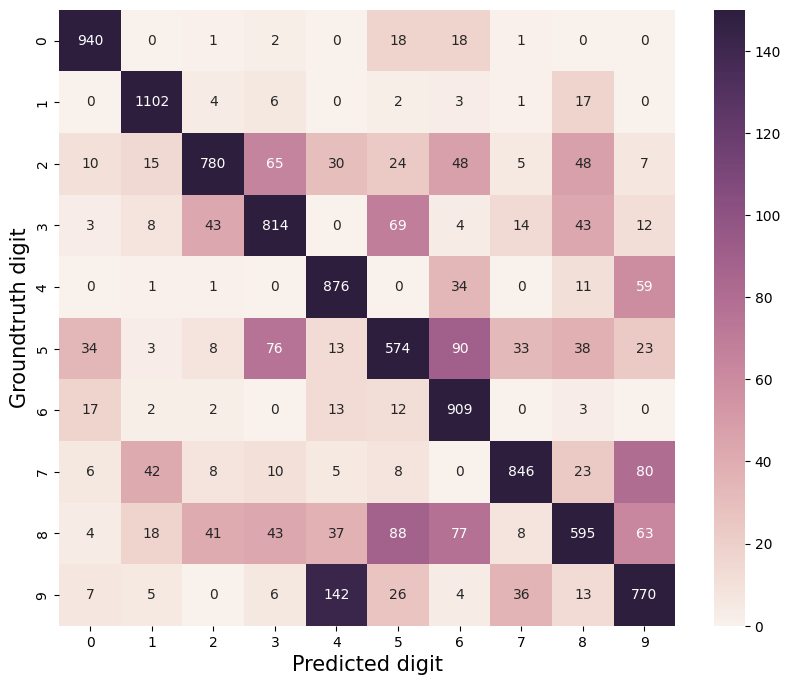

In [17]:
plot_confusion_matrix(classifier_softmax, trainer_softmax, test_dataloader)

### ReLU Activation Functions

We now change the internal activation functions from sigmoidal to ReLU function.

In [18]:
from torch.nn import ReLU

classifier_template.model.blocks[:].configure("activation", ReLU)
classifier_relu = classifier_template.create()
print(classifier_relu)

trainer_relu = dl.Trainer(max_epochs=1, accelerator="auto")
trainer_relu.fit(classifier_relu, train_dataloader)
trainer_relu.test(classifier_relu, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | MSELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | model         | MultiLayerPerceptron | 26.5 K
5 | optimizer     | SGD                  | 0     
-------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Classifier(
  (loss): MSELoss()
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LayerActivationNormalizationBlock(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): LayerActivationNormalizationBlock(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (out_layer): LayerActivationNormalizationBlock(
      (layer): Linear(in_features=32, out_features=10, bias=True)
      (activation): Softmax(dim=-1)
      (normalization): Identity()
    )
  )
  (optimizer): SGD[

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.9388999938964844      │
│       test_loss_epoch        │     0.009240709245204926     │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.009240709245204926,
  'testMulticlassAccuracy_epoch': 0.9388999938964844}]

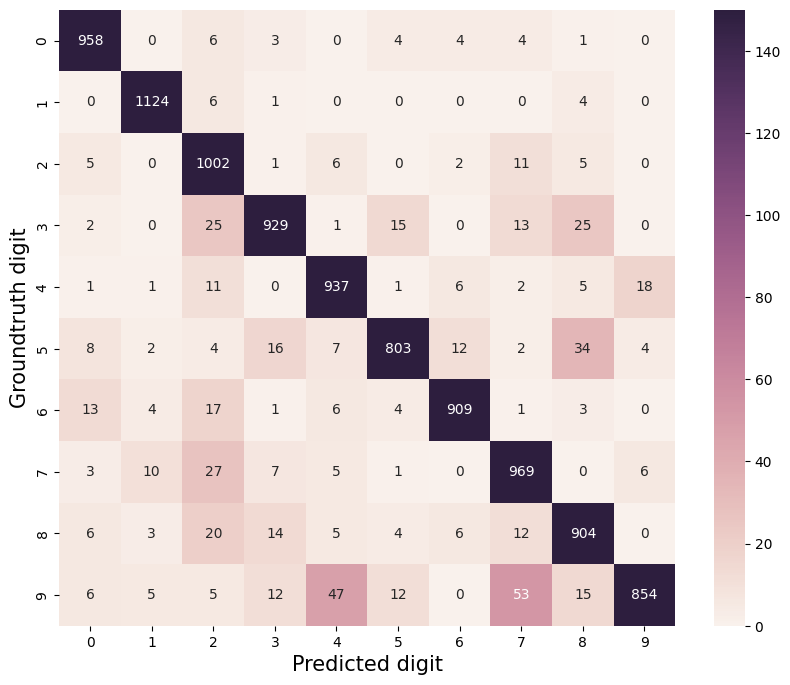

In [19]:
plot_confusion_matrix(classifier_relu, trainer_relu, test_dataloader)

### Mini Batches and Optimizer

We now introduce _mini-batches_ and, to better utilize the increased batch size, we use the `RMSprop` optimizer.

In [20]:
train_dataloader_batch = dl.DataLoader(train_images_digits, shuffle=True, 
                                       batch_size=16)

In [21]:
classifier_template.configure(optimizer=dl.RMSprop(lr=0.001))
classifier_rmsprop = classifier_template.create()
print(classifier_rmsprop)

trainer_rmsprop = dl.Trainer(max_epochs=10, accelerator="auto")
trainer_rmsprop.fit(classifier_rmsprop, train_dataloader_batch)
trainer_rmsprop.test(classifier_rmsprop, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | MSELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | model         | MultiLayerPerceptron | 26.5 K
5 | optimizer     | RMSprop              | 0     
-------------------------------------------------------
26.5 K    Trainable params
0         Non-trainable params
26.5 K    Total params
0.106     Total estimated model params size (MB)


Classifier(
  (loss): MSELoss()
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LayerActivationNormalizationBlock(
        (layer): Linear(in_features=784, out_features=32, bias=True)
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): LayerActivationNormalizationBlock(
        (layer): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (out_layer): LayerActivationNormalizationBlock(
      (layer): Linear(in_features=32, out_features=10, bias=True)
      (activation): Softmax(dim=-1)
      (normalization): Identity()
    )
  )
  (optimizer): RMSp

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.9660999774932861      │
│       test_loss_epoch        │     0.005304637365043163     │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.005304637365043163,
  'testMulticlassAccuracy_epoch': 0.9660999774932861}]

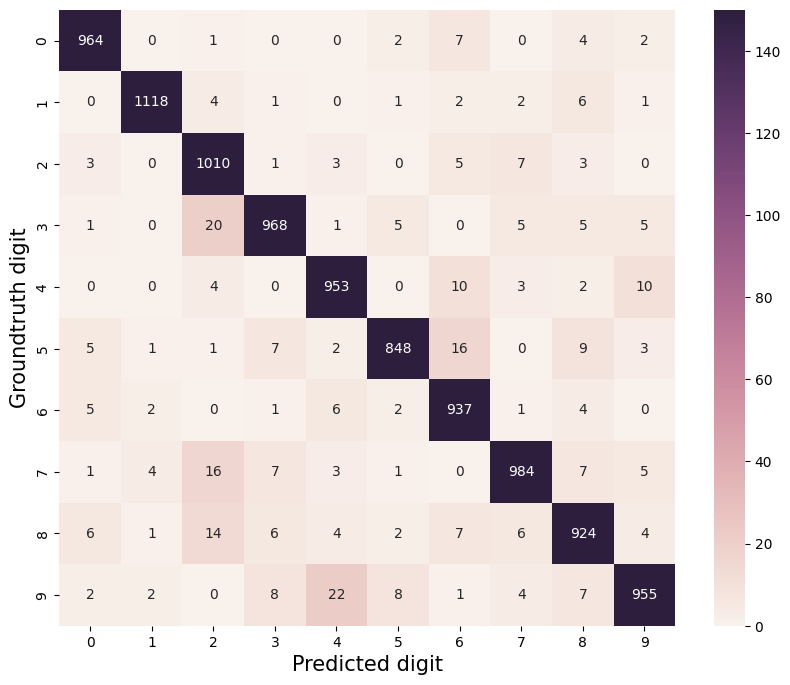

In [22]:
plot_confusion_matrix(classifier_rmsprop, trainer_rmsprop, test_dataloader)

## Failure Analysis

Checking for which inputs the neural network fails can suggests potential ways to improve its performance.

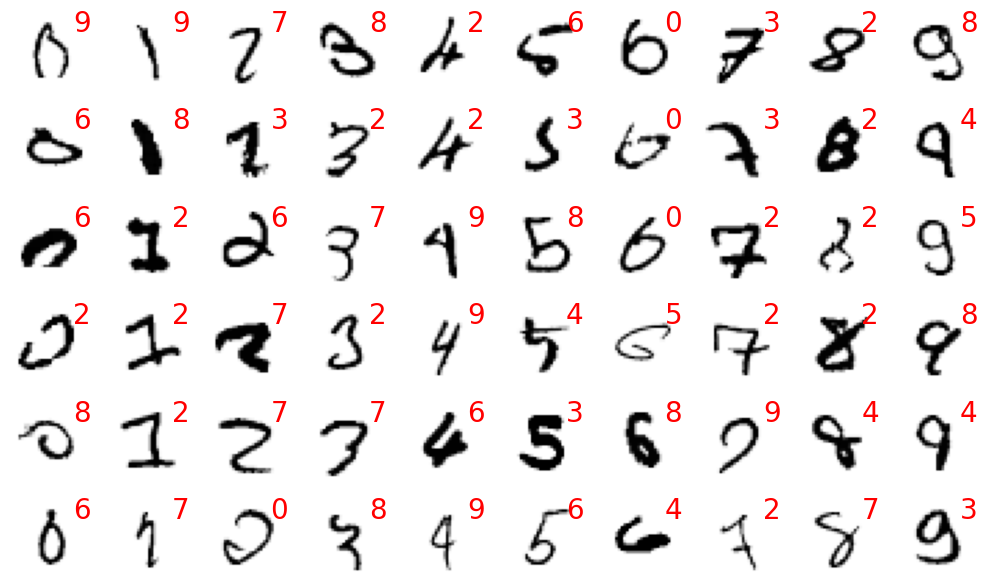

In [23]:
num_images_x_digit = 6

plt.figure(figsize=(10, num_images_x_digit))

num_failures_x_digit = np.zeros(10, int)
for image, gt_digit in test_dataloader:
    gt_digit = int(gt_digit)

    if num_failures_x_digit[gt_digit] < num_images_x_digit:
        predictions = classifier_rmsprop(image)
        max_predition, pred_digit = predictions.max(dim=1)

        if pred_digit != gt_digit:
            num_failures_x_digit[gt_digit] += 1

            plt.subplot(num_images_x_digit, 10, 
                        (num_failures_x_digit[gt_digit] - 1) * 10 + gt_digit + 1)
            plt.imshow(image.squeeze(), cmap="Greys")
            plt.annotate(str(int(pred_digit)), (.8, 1), (1, 1), 
                         xycoords="axes fraction", textcoords="offset points", 
                         va="top", ha="left", fontsize=20, color="red")
            plt.axis("off")
            
    if (num_failures_x_digit >= num_images_x_digit).all():
        break

plt.tight_layout()
plt.show()